# Pytorch 개발 Process

1. **데이터 준비**
    - Dataset 준비
    - Dataloader 생성

2. **입력과 출력을 연결하는 Layer(층)으로 이뤄진 네트워크(모델)을 정의**
    - **Sequential 방식**: 순서대로 쌓아올린 네트워크로 이뤄진 모델을 생성하는 방식
        - layer를 순서대로 쌓은 모델을 구현할때 간단히 모델을 정의할 수 있다.
        - layer block을 정의하는데 사용할 수 있다.
    - **Subclass 방식**: 네트워크를 정의하는 클래스를 구현.
        - 다양한 구조의 모델을 정의할 수 있다.
        - inializer에서 필요한 layer들을 생성한다.
        - forward(self, X) 메소드에 forward propagation 계산을 구현한다.
    

3. **train**
    - train 함수, test 함수 정의

4. test set 최종평가

# MNIST 이미지 분류 
- **[MNIST](https://ko.wikipedia.org/wiki/MNIST_%EB%8D%B0%EC%9D%B4%ED%84%B0%EB%B2%A0%EC%9D%B4%EC%8A%A4) (Modified National Institute of Standards and Technology) database**
- 흑백 손글씨 숫자 0-9까지 10개의 범주로 구분해놓은 데이터셋
- 하나의 이미지는 28 * 28 pixel 의 크기
- 6만개의 Train 이미지와 1만개의 Test 이미지로 구성됨.

## import

In [2]:
# torch: 공통 구현체
# torch.vision: 영상처리위한 구현체
import torch
import torch.nn as nn  # 딥러닝 모델을 궝하는 함수들의 모듈
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np

print('파이토치 버전:', torch.__version__)

파이토치 버전: 2.1.0


### device 설정

In [3]:
# 처리를 cpu를 이용할지 gpu를 이용할지 설정
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
print('device:', device)

device: mps


### 변수 설정

In [4]:
import os

In [5]:
# 뒤에서 여러번 사용할 값들을 저장할 변수 
# + 모델에 설정할 값(모델자체, 학습할 때 필요한값 등등)으로 성능에 영햐을 주는 값들을 저장할 변수
#        === 하이퍼 파라미터 (hyper parameter)

BATCH_SIZE = 256  # 모델의 파라미터를 업데이트할 때 사용할 데이터이 개수.  데이터 몇개 데이지를 입력할지
N_EPOCH = 20  # 전체 train dataset을 한번 학습한 것을 1epoch
LR = 0.001  # 학습률. 파라미터를 update할 때 gradient값에 곱해줄 값 (gradient룰 샤로운 파라미터 계산할 때 얼마나 반영할지 비윺)

# step: 파라미터를 1번 update하는 단위. 1step 당 학습데이터 수: batch_size
# epoch: 전체 학습데이터셋을 한번 학습한 단위, 1epoch 당 step 횟수 = ceil(총 데이터수/batch_size)

DATASET_SAVE_PATH ='datasets'  # 데이터셋을 저장할 디렉토리 경로
MODEL_SAVE_PATH = 'models'  # 학습-평가가 끝난 모델을 저장할 디렉토리 경로

os.makedirs(DATASET_SAVE_PATH, exist_ok=True)
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

In [6]:
np.ceil(60000/256)

235.0

## MNIST dataset Loading

### Dataset

In [7]:
### MNIST Dataset을 다운로드 + Dataset 객체를 생성
# train dataset
# torchvision.datasets
train_set = datasets.MNIST(root=DATASET_SAVE_PATH,  # 데이터셋을 저장할 디렉토리 경로
                           train=True,  # trainset(훈련용): True, testset(검증용): False
                           download=True, # root에 저장된 데이터파일들이 없을 떼 다운로드 받을지 여부
                           transform=transforms.ToTensor() # 데이터 전처리
                          )
# ToTensor(): ndarray, PIL.Image 객체 -> torch.Tensor로 변환. 
#             pixcel값 정규화(normalization): 0 ~ 1 실수로 변환
test_set = datasets.MNIST(root=DATASET_SAVE_PATH,
                          train=False,
                          download=True,
                          transform=transforms.ToTensor()
                         )

In [8]:
print(type(train_set))  # Dataset 타입
print(train_set)
print(test_set)

<class 'torchvision.datasets.mnist.MNIST'>
Dataset MNIST
    Number of datapoints: 60000
    Root location: datasets
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: datasets
    Split: Test
    StandardTransform
Transform: ToTensor()


In [9]:
# 데이터 포인트 개수
print(len(train_set), len(test_set))

60000 10000


### DataLoader

In [10]:
# Dataset을 모델에 어떻게 제공할지를 설정 => 학습/평가시 설정된대로 데이터를 Loading
# 훈련용 DataLoader
train_loader = DataLoader(train_set, # Dataset
                          batch_size=BATCH_SIZE,  # batch_size를 설정
                          shuffle=True,  # 한 epoch이 끝나면 다음 epoch 전에 데이터를 섞을지 여부
                          drop_last=True,  # 마지막 batch의 데이터수가 batch_size보다 적을 경우 버릴지(학습에 사용안함) 여부
                         )
# 평가용 DataLoader
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE)

In [11]:
print('1 에폭당 step 수')
print('trainset:', len(train_loader))
print('testset:', len(test_loader))

1 에폭당 step 수
trainset: 234
testset: 40


In [12]:
np.floor(60000/256), np.ceil(10000/256)

(234.0, 40.0)

- Dataset: input/output data를 묶어서 관리
- DataLoader: Dataset의 데이터들을 모델에 어떻게 제공할지를 관리

## 네트워크(모델) 정의
- Network : 전체 모델 구조

In [13]:
# class로 정의: nn.Module 을 상속해서 정의
class MnistModel(nn.Module):
    
    def __init__(self):
        """
        모델 객체 생성시 모델을 구현(정의)할 때 필요한 것들을 초기화
        필요한 것: Layer들. 등등
        """
        super().__init__()
        
        # 784(pixcel수) -> 128개로 축소
        self.lr1 = nn.Linear(28*28, 128)  # input feature 크기, output size
        # 128 feature -> 64 축소
        self.lr2 = nn.Linear(128, 64)
        # 64 feature -> 출력결과 10 (각 범주의 확률)
        self.lr3 = nn.Linear(64, 10)
        # Activation(활성) 함수 -> 비선형함수: ReLU
        self.relu = nn.ReLU() # f(x) = max(x, 0)
        
    def forward(self, x):
        """
        input data를 입력 받아서 최종 output 데이터를 만들 때까지의 계산 흐름을 정의
        ===> forward propagation
        parameter
            x: 입력데이터
        return
            torch.Tensor: 출력데이터(모델 예측결과)
        """
        # init에서 생성한 함수들을 이용해서 계산
        ### x -> 1차원으로 변환 -> lr1 -> relu -> lr2 -> relu -> lr3 -> output
        # input (batch_size, channel, height, width) => (batch_size, 전체 pixcel)
        x = torch.flatten(x, start_dim=1)  # (b, c, h, w) -> (b, c*h*w)
        
        x = self.lr1(x)
        x = self.relu(x)
        
        x = self.lr2(x)
        x = self.relu(x)
        
        output = self.lr3(x)
        return output

In [14]:
i = torch.arange(28*28).reshape(1, 1, 28, 28)
i.shape  # [1:데이터개수, 1:channel, 28:height, 28:width]
# -> 1차원 => 데이터개수는 유지 [1, 784]
## 다차원 텐서 => 1차원 => flatten([start_dim=axis])  # 지정한 axis부터 합침
# torch.flatten(i).shape
torch.flatten(i, start_dim=1).shape  # axis 0은 유지하고, axis 1부터 나머지를 합침

torch.Size([1, 784])

In [15]:
# 정의한 모델 클래스로부터 모델 객체를 생성
model = MnistModel()
print(model)

MnistModel(
  (lr1): Linear(in_features=784, out_features=128, bias=True)
  (lr2): Linear(in_features=128, out_features=64, bias=True)
  (lr3): Linear(in_features=64, out_features=10, bias=True)
  (relu): ReLU()
)


In [16]:
# 모델의 연산 흐름 및 정보를 확인 => torchinfo 패키지를 사용
!pip install torchinfo

In [17]:
from torchinfo import summary
summary(model, (256, 1, 28, 28)) # summary(모델객체, input shape: tuple)

Layer (type:depth-idx)                   Output Shape              Param #
MnistModel                               [256, 10]                 --
├─Linear: 1-1                            [256, 128]                100,480
├─ReLU: 1-2                              [256, 128]                --
├─Linear: 1-3                            [256, 64]                 8,256
├─ReLU: 1-4                              [256, 64]                 --
├─Linear: 1-5                            [256, 10]                 650
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
Total mult-adds (M): 28.00
Input size (MB): 0.80
Forward/backward pass size (MB): 0.41
Params size (MB): 0.44
Estimated Total Size (MB): 1.65

In [18]:
# train dataset의 첫번째 배치를 이용해서 모델에 추론
x_batch, y_batch = next(iter(train_loader))  # (input, output)
print(x_batch.shape, y_batch.shape)

torch.Size([256, 1, 28, 28]) torch.Size([256])


In [19]:
# 추론
pred_batch = model(x_batch)  # model의 forward() 메소드가 실행
pred_batch.shape

torch.Size([256, 10])

In [20]:
# 첫번째 이미지에 대한 추론결과 -> class별 확률 => 가장 큰 확률의 index를 조회
pred_batch[0].argmax()

tensor(7)

In [21]:
y_batch[0]

tensor(0)

In [22]:
torch.sum(pred_batch.argmax(dim=1) == y_batch)  # 맞은 개수

tensor(36)

In [24]:
36/256

0.140625

## train

### 모델, loss function, optimizer 생성

In [25]:
# 모델을 device로 옮긴다 (모델을 이용한 계산을 CPU에서 할지 GPU에서 할지)
# 참고: device로 옮기는 것 => model, 학습시킬 input data, output data
# model = MnistModel()
model = model.to(device)

# Loss function
# 다중분류문자: crossentropy, 이진분류문제: binary crossentropy ==> log loss
# 다중분류: label이 여러개, 이진분류: yes/no 분류
loss_fn = nn.CrossEntropyLoss()  # 객체, or nn.functional.cross_entropy() 함수

# Optimizer ==> 모델 파라미터들 최적화
optimizer = torch.optim.Adam(model.parameters(),  # 최적화 대상 파라미터들
                             lr=LR  # 학습률
                            )

In [27]:
# model.parameters(): generator
a = next(model.parameters())
a.shape
a

Parameter containing:
tensor([[ 0.0228, -0.0309,  0.0165,  ..., -0.0341, -0.0219, -0.0196],
        [ 0.0056, -0.0076,  0.0255,  ..., -0.0051,  0.0335,  0.0352],
        [-0.0278,  0.0293, -0.0228,  ...,  0.0035, -0.0019,  0.0049],
        ...,
        [-0.0232, -0.0185, -0.0105,  ..., -0.0350, -0.0197, -0.0171],
        [ 0.0067, -0.0295,  0.0115,  ...,  0.0018,  0.0293, -0.0303],
        [-0.0264, -0.0226, -0.0085,  ..., -0.0025, -0.0218,  0.0119]],
       device='mps:0', requires_grad=True)

### 학습 및 검증

In [33]:
import time # 학습시간체크

# 학습 => train(훈련) + validation(1 epoch 학습한 모델성능 검증)
# 에폭(epoch)별 학습결과를 저장할 리스트들
train_loss_list = []    # train set으로 검증했을 때 loss(loss_fn 계산값)
val_loss_list = []      # test set으로 검증했을 때 loss
val_accuracy_list = []  # test set으로 검증했을 때 accuracy(정확도)-전체 중 맞은 비율

start = time.time()
# Train
for epoch in range(N_EPOCH):
    ################################
    # Train
    ################################
    model.train()  # 모델을 train모드로 변경
    train_loss = 0.0  # 현재 epoch의 학습 결과 loss를 저장할 변수
    # 배치단위로 학습
    for X_train, y_train in train_loader:  # batch 단위 (input, output) 튜플로 반환
        # 1. X, y를 device로 옮긴다 (model, X, y는 같은 device상에 위치해야 함)
        X_train, y_train = X_train.to(device), y_train.to(device)
        
        # 2. 추론
        pred = model(X_train)
        
        # 3. Loss 계산
        loss = loss_fn(pred, y_train)  # args 순서: (모델예측값, 정답)
        
        # 4. 모델의 파라미터 업데이트(최적화)
        ## 1. 파라미터의 graddient값들을 초기화
        optimizer.zero_grad()
        ## 2. graddient 계산 ==> 계산결과는 파라미터.grad 속성에 저장
        loss.backward()
        ## 3. 파라미터(weight, bias) 업데이트 (파라미터 - 학습률*grad)
        optimizer.step()
        
        # 현재 batch의 loss값을 train_loss변수에 누적
        train_loss += loss.item()  # Tensor -> 파이썬 값
        
    # 1epoch학습 종료
    # epoch의 평균 loss를 계산해서 저장 (train_loss: step별 loss를 누적)
    train_loss_list.append(train_loss / len(train_loader)) # step수 나눔
    
    
    ################################
    # validation(검증) - test(validation) set (학습할 때 사용하지 않았던 데이터셋)
    ################################
    model.eval()  # 모델을 검증(평가) 모드로 전환
    # 현재 epoch에 대한 검증결과(loss, accuracy)를 저장할 변수
    val_loss = 0.0
    val_acc = 0.0
    # 모델 추정을 위한 연산 - forward propagation
    ## 검증/평가/서비스 - gradient계산이 필요없다 => 도함수를 계산할 필요 없다
    with torch.no_grad():
        ## batch 단위로 검증
        for X_val, y_val in test_loader:
            # 1. device로 옮기기
            X_val, y_val = X_val.to(device), y_val.to(device)
            # 2. 모델을 이용해 추론
            pred_val = model(X_val)
            # 3. 검증 
            ## 1. loss 계산 + val_loss에 누적
            val_loss = val_loss + loss_fn(pred_val, y_val).item()
            ## 2. 정확도(accuracy): 맞은 것 개수 / 전체 개수
            val_acc = val_acc + torch.sum(pred_val.argmax(axis=-1) == y_val).item()
        # test set 전체에 대한 검증이 완료 => 현 epoch에 대한 검증 완료
        ## val_loss, val_acc 값을 리스트에 저장
        val_loss_list.append(val_loss / len(test_loader))  # loss는 step수(len(test_loader))로 나눔
        val_accuracy_list.append(val_acc / len(test_loader.dataset))  # 전체 데이터 개수로 나눈다
    ## 현재 eopch train 결과를 출력
    print(f'[{epoch+1:2d}/{N_EPOCH:2d}] Train Loss: {train_loss_list[-1]}, Val Loss: {val_loss_list[-1]}, Val Accuracy: {val_accuracy_list[-1]}')
    
    
end = time.time()
print(f'학습에 걸린시간: {end-start}초')

[ 1/20] Train Loss: 0.16540350144108137, Val Loss: 0.14331169608049094, Val Accuracy: 0.9558
[ 2/20] Train Loss: 0.1292990474269176, Val Loss: 0.11894981649238616, Val Accuracy: 0.9633
[ 3/20] Train Loss: 0.10276322038127826, Val Loss: 0.10410003084689379, Val Accuracy: 0.9673
[ 4/20] Train Loss: 0.08474545890035537, Val Loss: 0.09638020556885749, Val Accuracy: 0.9712
[ 5/20] Train Loss: 0.07256505152799635, Val Loss: 0.08544376238714904, Val Accuracy: 0.9734
[ 6/20] Train Loss: 0.06062347308183328, Val Loss: 0.08174916822172236, Val Accuracy: 0.974
[ 7/20] Train Loss: 0.053069183435768656, Val Loss: 0.07563119677652139, Val Accuracy: 0.9778
[ 8/20] Train Loss: 0.04488583093779719, Val Loss: 0.07732527888001642, Val Accuracy: 0.9757
[ 9/20] Train Loss: 0.03817503108109674, Val Loss: 0.08674959026684519, Val Accuracy: 0.9743
[10/20] Train Loss: 0.03318552632266895, Val Loss: 0.07525212255495717, Val Accuracy: 0.9765
[11/20] Train Loss: 0.028266284340180647, Val Loss: 0.07862604238762287

### 학습 로그 시각화

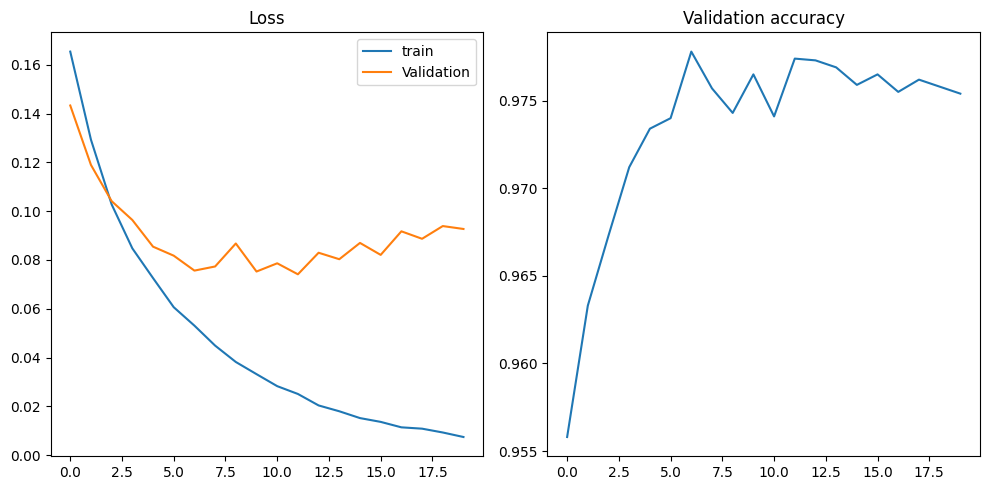

In [35]:
# acc보다 loss값이 더 작은게 좋은 것
# epoch별 loss, accuracy의 변화의 흐름을 시각화
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(N_EPOCH), train_loss_list, label='train')
plt.plot(range(N_EPOCH), val_loss_list, label='Validation')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(N_EPOCH), val_accuracy_list)
plt.title('Validation accuracy')

plt.tight_layout()
plt.show()

## 학습된 모델 저장 및 불러오기

In [38]:
save_path = os.path.join(MODEL_SAVE_PATH, "mnist")
os.makedirs(save_path, exist_ok=True)

save_file_path = os.path.join(save_path, 'mnist_mlp.pth')
print(save_file_path)

models/mnist/mnist_mlp.pth


In [39]:
torch.save(model, save_file_path)

In [41]:
# 모델 불러오기
load_model = torch.load(save_file_path)
load_model

MnistModel(
  (lr1): Linear(in_features=784, out_features=128, bias=True)
  (lr2): Linear(in_features=128, out_features=64, bias=True)
  (lr3): Linear(in_features=64, out_features=10, bias=True)
  (relu): ReLU()
)

In [43]:
from torchinfo import summary
summary(load_model, (BATCH_SIZE, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
MnistModel                               [256, 10]                 --
├─Linear: 1-1                            [256, 128]                100,480
├─ReLU: 1-2                              [256, 128]                --
├─Linear: 1-3                            [256, 64]                 8,256
├─ReLU: 1-4                              [256, 64]                 --
├─Linear: 1-5                            [256, 10]                 650
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
Total mult-adds (M): 28.00
Input size (MB): 0.80
Forward/backward pass size (MB): 0.41
Params size (MB): 0.44
Estimated Total Size (MB): 1.65

## 모델 평가

In [53]:
# device로 옮기기
load_model = load_model.to(device)
# 평가모드로 변환
load_model.eval()

test_loss, test_acc =0.0, 0.0
with torch.no_grad():
    for X, y in test_loader:
        # device 옮기기
        X, y = X.to(device), y.to(device)
        # 추정
        pred = load_model(X)
        # 평가- loss, accuraccy
        test_loss += loss_fn(pred, y)
        test_acc += torch.sum(pred.argmax(axis=-1) == y).item()
    test_loss /= len(test_loader)  # step 수로 나누기
    test_acc /= len(test_loader.dataset)  # 총 데이터 수로 나누기
print(f"Test loss: {test_loss}, Test accuracy: {test_acc}")

Test loss: 0.09269838035106659, Test accuracy: 0.9754


## 새로운 데이터 추론

In [55]:
!pip install opencv-contrib-python

  Obtaining dependency information for opencv-contrib-python from https://files.pythonhosted.org/packages/d7/c1/8807b1145c89f64734517ab18f0acc11e021059cd8fdf5c765f4633ae0bc/opencv_contrib_python-4.8.1.78-cp37-abi3-macosx_10_16_x86_64.whl.metadata
  Using cached opencv_contrib_python-4.8.1.78-cp37-abi3-macosx_10_16_x86_64.whl.metadata (19 kB)
Using cached opencv_contrib_python-4.8.1.78-cp37-abi3-macosx_10_16_x86_64.whl (64.4 MB)


In [56]:
from glob import glob
import cv2

In [57]:
img_file_list = glob('test_img/num/*.png')
img_file_list

['test_img/num/three.png',
 'test_img/num/eight2.png',
 'test_img/num/three2.png',
 'test_img/num/two.png',
 'test_img/num/four.png',
 'test_img/num/eight.png',
 'test_img/num/five.png',
 'test_img/num/one.png',
 'test_img/num/seven.png',
 'test_img/num/seven2.png']

In [59]:
file_cnt = len(img_file_list)
print('개수:', file_cnt)
input_tensor = torch.zeros((file_cnt, 28, 28))  # 분류할 이미지를 저장할 변수

for i in range(file_cnt):
    # image읽기
    test_img = cv2.imread(img_file_list[i], cv2.IMREAD_GRAYSCALE)
    # 28 x 28 리사이즈
    test_img = cv2.resize(test_img, (28, 28))
    # ndarray -> torch.Tensor + 정규화 (0 ~ 1) => input_tensor에 추가
    input_tensor[i] = transforms.ToTensor()(test_img)

개수: 10


In [62]:
print(type(input_tensor))
print(input_tensor.shape)
print(input_tensor.min(), input_tensor.max())

<class 'torch.Tensor'>
torch.Size([10, 28, 28])
tensor(0.) tensor(1.)


In [65]:
# 추론
load_model.to(device)
load_model.eval()

input_tensor = input_tensor.to(device)

pred_new = load_model(input_tensor)
# 모델이 예측한 값을 확률로 변환 => softmax 함수
pred_proba = nn.Softmax(dim=-1)(pred_new)

print(pred_new.shape, pred_proba.shape)

torch.Size([10, 10]) torch.Size([10, 10])


In [66]:
pred_proba

tensor([[6.4749e-04, 4.6835e-06, 6.2576e-03, 9.9287e-01, 7.3143e-08, 1.7512e-04,
         2.7681e-06, 3.5523e-05, 4.9818e-06, 7.9879e-08],
        [1.4644e-15, 2.3468e-06, 1.1189e-14, 7.0506e-06, 1.8316e-20, 9.9999e-01,
         1.0554e-07, 1.7142e-14, 1.6461e-07, 1.4467e-18],
        [8.9983e-06, 1.3682e-06, 1.7748e-07, 9.9147e-01, 8.2948e-09, 1.5060e-03,
         2.2873e-06, 8.7354e-10, 6.9513e-03, 5.8103e-05],
        [1.1107e-11, 6.0517e-08, 9.9996e-01, 1.0368e-06, 1.1132e-16, 3.8773e-10,
         4.5630e-15, 5.6460e-09, 3.5059e-05, 3.5731e-13],
        [9.8169e-07, 2.2659e-09, 1.1015e-02, 1.4919e-07, 9.8895e-01, 5.7494e-07,
         5.4027e-07, 2.6804e-05, 2.0390e-08, 8.9531e-06],
        [2.5762e-04, 7.1522e-03, 8.9154e-01, 1.2840e-02, 1.3810e-07, 1.1921e-04,
         1.8287e-02, 2.4624e-06, 6.9806e-02, 3.0110e-11],
        [6.2802e-12, 7.1680e-07, 5.9539e-08, 1.6878e-04, 4.2609e-10, 9.9966e-01,
         3.4840e-09, 2.8528e-10, 1.6850e-04, 1.1675e-06],
        [6.5480e-02, 2.0449

In [67]:
# pred_proba.sum(axis=-1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='mps:0', grad_fn=<SumBackward1>)

In [86]:
pred_label_proba = pred_proba.max(dim=-1).values
pred_label_proba

tensor([0.9929, 1.0000, 0.9915, 1.0000, 0.9889, 0.8915, 0.9997, 0.5380, 0.9996,
        0.5420], device='mps:0', grad_fn=<MaxBackward0>)

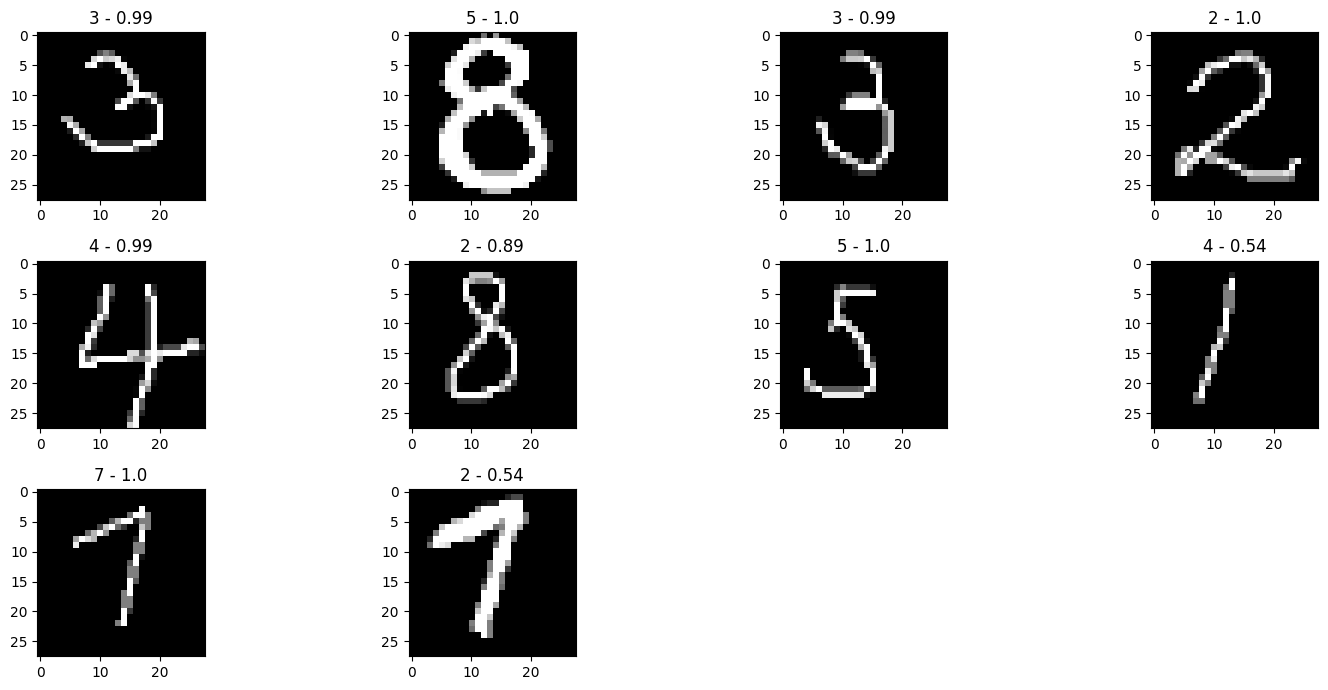

In [87]:
plt.figure(figsize=(15, 7))
for i in range(file_cnt):
    plt.subplot(3, 4, i+1)
    plt.imshow(input_tensor[i].to('cpu').numpy(), cmap='gray')
    plt.title(f'{pred_label[i].item()} - {pred_label_proba[i].item():.2}')
    
plt.tight_layout()
plt.show()